In [1]:
import sys
from pathlib import Path
from types import SimpleNamespace

import matplotlib.pyplot as plt
import numpy as np
import torch
from ipywidgets import interact
from tqdm import tqdm

sys.path.append("../mosquito")

from pylib import stripe  # noqa
from pylib import tile  # noqa
from pylib import trainer_engine as trainer  # noqa
from pylib.simple_unet import SimpleUNet  # noqa
from pylib.tile_dataset import TileDataset  # noqa

In [2]:
args = SimpleNamespace(
    stripe_csv=Path("../data/stripes.csv"),
    layer_path=[
        Path("../data/layers/dem.tif"),
        Path("../data/layers/fa.tif"),
        Path("../data/layers/slope.tif"),
        Path("../data/layers/wetness.tif"),
    ],
    target_file=Path("../data/layers/larv_spot_50m_correct.tif"),
    save_model=Path("../data/models"),
    load_model=None,
    lr=0.00001,
    train_stride=192,
    val_stride=256,
    tile_size=512,
    batch_size=32,
    workers=4,
    epochs=100,
    log_dir=None,
    limit=None,
)

In [3]:
layers, target = trainer.get_images(args)

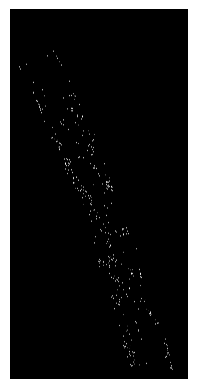

In [4]:
plt.figure()
plt.imshow(target[0], cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [5]:
stripes = stripe.read_stripes(args.stripe_csv, "train")
tiles = tile.get_tiles(stripes, limits=target.shape[1:], stride=args.train_stride)
dataset = TileDataset(tiles, layers, target, augment=True)

In [6]:
def show(idx):
    image, y_true = dataset[idx]

    print(np.isnan(np.sum(image)))

    fig, axes = plt.subplots(
        nrows=2, ncols=3, sharex=True, sharey=True, figsize=(24, 16)
    )
    ax = axes.ravel()

    ax[0].imshow(image[0], cmap=plt.cm.gray)
    ax[0].set_title("dem")
    ax[0].axis("off")

    ax[1].imshow(image[1], cmap=plt.cm.gray)
    ax[1].set_title("fa")
    ax[1].axis("off")

    ax[2].imshow(image[2], cmap=plt.cm.gray)
    ax[2].set_title("slope")
    ax[2].axis("off")

    ax[3].imshow(image[3], cmap=plt.cm.gray)
    ax[3].set_title("wetness")
    ax[3].axis("off")

    ax[4].axis("off")

    ax[5].imshow(y_true[0], cmap=plt.cm.gray)
    ax[5].set_title("larvae")
    ax[5].axis("off")

    plt.show()


interact(show, idx=(0, len(tiles)))

interactive(children=(IntSlider(value=2696, description='idx', max=5393), Output()), _dom_classes=('widget-int…

<function __main__.show(idx)>

In [7]:
unet = SimpleUNet()

In [9]:
beg = 5000
for i, t in tqdm(enumerate(tiles[beg:], beg), total=len(tiles[beg:])):
    image = [layers[:, t.top:t.bottom, t.left:t.right]]
    x = torch.from_numpy(np.array(image))
    x = unet.forward(x)
    if x.isnan().any():
        out = str(i)
        for j, lay, in enumerate(x[0]):
            if lay.isnan().any():
                out += " " + str(j)
        print(out)

 46%|██████████████████████████████████████████████▎                                                     | 182/393 [00:51<01:01,  3.43it/s]

5181 0


 47%|██████████████████████████████████████████████▌                                                     | 183/393 [00:51<01:00,  3.45it/s]

5182 0


 57%|█████████████████████████████████████████████████████████▎                                          | 225/393 [01:03<00:51,  3.24it/s]

5224 0


 68%|███████████████████████████████████████████████████████████████████▉                                | 267/393 [01:15<00:34,  3.67it/s]

5266 0


 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 308/393 [01:25<00:21,  3.92it/s]

5307 0


 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 309/393 [01:25<00:21,  3.93it/s]

5308 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 350/393 [01:36<00:11,  3.87it/s]

5349 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 351/393 [01:36<00:10,  3.88it/s]

5350 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▋| 392/393 [01:47<00:00,  3.79it/s]

5391 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 393/393 [01:47<00:00,  3.64it/s]

5392 0


In [12]:
t = tiles[5181]
image = layers[:, t.top:t.bottom, t.left:t.right]
image[0]

array([[ 4.0003090e+00,  3.9771123e+00,  3.9511900e+00, ...,
        -8.8542700e-03, -1.0271705e-03,            nan],
       [ 4.0549617e+00,  4.0098433e+00,  3.9753520e+00, ...,
        -8.8542700e-03, -1.0271705e-03,            nan],
       [ 4.0643144e+00,  4.0418382e+00,  3.9860785e+00, ...,
        -8.8542700e-03, -1.0271705e-03,            nan],
       ...,
       [ 4.3913574e+00,  4.2252350e+00,  4.0163112e+00, ...,
        -8.8542700e-03, -1.0271705e-03,            nan],
       [ 3.9985044e+00,  3.9826050e+00,  3.8196900e+00, ...,
        -8.8542700e-03, -1.0271705e-03,            nan],
       [ 3.8504720e+00,  3.8806260e+00,  3.8301361e+00, ...,
        -8.8542700e-03, -1.0271705e-03,            nan]], dtype=float32)